<a href="https://colab.research.google.com/github/lit2020/class-deep-learning/blob/main/%5BDL%5D201902656_%EA%B9%80%EA%B8%B0%EC%9B%85_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import torch
import torch.nn as nn # layers, loss functions
import torch.nn.functional as F # F.softmax

from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt
import random

# Cuda setting

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
random.seed(1214)
torch.manual_seed(1214)
if device == 'cuda':
    torch.cuda.manual_seed_all(1214)

cuda


# load dataset

In [ ]:
train_dataset =  torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset =  torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:03<00:00, 3135231.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 467759.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4531658.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 9501510.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Models

In [ ]:
# HW2 (classification)
class MLP_model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_model, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes

        self.layers = nn.ModuleList()
        self.activation = nn.LeakyReLU(negative_slope=0.02)

        self.layers.append(nn.Linear(input_size, 512))
        self.layers.append(nn.Dropout(p=0.25)),
        self.layers.append(nn.BatchNorm1d(512, momentum=0.2))
        self.layers.append(self.activation)

        self.layers.append(nn.Linear(512, 256))
        self.layers.append(nn.BatchNorm1d(256, momentum=0.2))
        self.layers.append(self.activation)

        self.layers.append(nn.Linear(256, 128))
        self.layers.append(nn.BatchNorm1d(128, momentum=0.2))
        self.layers.append(self.activation)

        self.layers.append(nn.MaxPool1d(3, padding=1, stride=2))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(64, 32))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(32, num_classes))

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)

        return output

In [ ]:
# HW2 (classification)
class MLP_model_seq(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_model_seq, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes

        self.activation = nn.ReLU()
        self.layers = []
        self.layers.append(nn.Linear(input_size, 256))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(256, 128))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(128, 64))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(64, num_classes))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        output = self.model(x)

        return output

In [ ]:
# HW2 (classification) 과제에는 없지만 그냥 사용해봄
class Cnn(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Cnn, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        # (1, 28, 28)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(1, 1, kernel_size=5, padding=2))# (1, 28, 28)
        self.layers.append(nn.Conv2d(1, 1, kernel_size=3, padding=1)) # (1, 28, 28)
        self.layers.append(nn.Conv2d(1, 1, kernel_size=3, stride=2)) # (1, 13, 13)
        self.layers.append(nn.MaxPool2d(2)) # (1, 12, 12)
        self.layers.append(nn.Flatten()) # (144)
        self.layers.append(nn.Linear(12 * 12, 128))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(128, 128))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(128, 64))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(64, num_classes))
        self.layers.append(nn.ReLU())

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)

        return output


In [ ]:
# HW3 (Regularization, Optimization)
class Batch_Norm(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Batch_Norm, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.activation = nn.LeakyReLU(negative_slope=0.02)
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256, momentum=0.04),
            self.activation,

            nn.Linear(256, 128),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(128),
            self.activation,

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(3, padding=1, stride=2),
            self.activation,

            nn.Linear(32, 10)
        )

    def forward(self, x):
        output = self.network(x)

        return output

# Hyper Parameters

In [ ]:
# parameters
input_size = 28 * 28
num_classes = 10
n_epochs = 10
learning_rate = 0.01

In [ ]:
batch_size = 100
train_loader= DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model Selection
#### learn only 1 cell

MLP model

In [ ]:
model = MLP_model(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

MLP model with nn.Sequential()



In [ ]:
model = MLP_model_seq(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

CNN model

In [ ]:
model= Cnn(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Batch_Norm

In [ ]:
model= Batch_Norm(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adams(model.parameters(), lr = learning_rate)

# Train

In [ ]:
loss_list = []
loss_train = []
for cnt_epoch in range(n_epochs):
    avg_cost = 0
    # train을 위한 모드 설정
    # Drop out과 같은 레이어는, 훈련단계와 평가단계에서의 동작이 다름
    model.train()
    for cnt_batch, (x, y) in enumerate(train_loader):
        x = x.reshape(-1, 28 * 28)
        x_input = x.to(device)

        y_input = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x_input)
        loss = criterion(y_pred, y_input)
        loss.backward()
        optimizer.step()

        avg_cost += loss.item() / batch_size
        loss_list.append(loss)
    print("Epoch {} Loss {:.5f}".format(cnt_epoch + 1, avg_cost))
    loss_train.append(avg_cost)


Epoch 1 Loss 1.49107
Epoch 2 Loss 0.74377
Epoch 3 Loss 0.54549
Epoch 4 Loss 0.43991
Epoch 5 Loss 0.36420
Epoch 6 Loss 0.30985
Epoch 7 Loss 0.26914
Epoch 8 Loss 0.24606
Epoch 9 Loss 0.22996
Epoch 10 Loss 0.19717


# Plot Train Loss

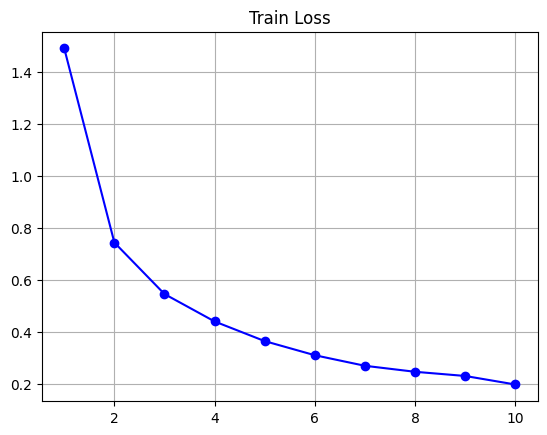

In [ ]:
plt.plot([i for i in range(1, n_epochs+1)], loss_train, 'bo-', label='Train Loss')
plt.grid()
plt.title("Train Loss")
plt.show()

# Validation

In [ ]:
with torch.no_grad():
    num_total_data = 0
    correct = 0

    # validation, evaluation을 위한 모드 설정
    # Drop out과 같은 레이어는, 훈련단계와 평가단계에서의 동작이 다름
    model.eval()
    for cnt_batch, (x, y) in enumerate(test_loader):
        x = x.reshape(-1, 28 * 28)
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        y_pred = F.softmax(y_pred, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)
        num_total_data += len(x)
        correct += sum(y == y_pred).item()

print("Model Accuracy : {:.5f}".format(correct / num_total_data))

Model Accuracy : 0.98270


# Model Summary

In [ ]:
for layer in model.children():
    print(layer)

ReLU()
Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.04, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Dropout(p=0.3, inplace=False)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
m = nn.Conv2d(1, 4, kernel_size=3, padding=1)
input = torch.randn(100, 4, 12, 12)
flat = nn.Flatten()
output = flat(input)

In [ ]:
m2 = nn.Conv2d(4, 2, kernel_size=5, padding=2)
output2 = m2(output)

In [ ]:
print(input.shape)
print(output.shape)

torch.Size([100, 4, 12, 12])
torch.Size([100, 576])


In [ ]:
pooling_layer = nn.MaxPool2d(3, stride=2)
output = pooling_layer(output)

In [ ]:
print(output.shape)

torch.Size([100, 4, 13, 13])


In [ ]:
# With Learnable Parameters
m = nn.BatchNorm1d(5)
input = torch.randn(3, 5)
output = m(input)


In [ ]:
print(input.shape)
print(output.shape)

torch.Size([3, 5])
torch.Size([3, 5])


In [ ]:
print(input)
print(output)
print(output[0])

tensor([[-1.0967,  0.4810, -1.5182, -0.5899,  0.0825],
        [-0.5428,  1.4874, -0.0942,  0.0334,  0.6678],
        [-0.8445,  1.1155,  0.2492, -0.9468,  0.0562]])
tensor([[-1.1866, -1.3164, -1.3903, -0.2192, -0.6600],
        [ 1.2594,  1.1057,  0.4707,  1.3195,  1.4131],
        [-0.0727,  0.2107,  0.9195, -1.1003, -0.7531]],
       grad_fn=<NativeBatchNormBackward0>)
tensor([-1.1866, -1.3164, -1.3903, -0.2192, -0.6600],
       grad_fn=<SelectBackward0>)


In [ ]:
print(sum(output[0]))
print(sum(input[0]))

tensor(-4.7725, grad_fn=<AddBackward0>)
tensor(-2.6413)


In [ ]:
print(nn.Linear(30, 32))

Linear(in_features=30, out_features=32, bias=True)
